# Replicating OpenScope Credit Assignment project figures 

In this notebook, we will replicate figures from the OpenScope Credit Assignment project. All of these figures were published in the dataset descriptor paper {cite}`Gillon2023`, except for the final figure which is from the analysis paper {cite}`Gillon2024`. See these papers for full details on the project and dataset.

The objective of collecting and sharing this dataset was to enable users to study how different compartments of visual cortex pyramidal neurons respond when inconsistent (i.e., unexpected or pattern-violating) features are introduced into the stimuli that mice are viewing. To achieve this, we first habituated mice to stimuli with consistent features, before introducing inconsistent features while recording neuronal activity in the somata (i.e., cell bodies) or distal apical dendrites of layer 2/3 or layer 5 pyramidal neurons in primary visual cortex.  

Since the full analyses performed on this dataset require a larger codebase (and in some cases, longer compute time) than is convenient for a notebook, this notebook focuses on replicating a few figures from data dictionaries. These data dictionaries were generated using the full analysis pipeline, and contain all the information needed to plot the associated figures.

To work with the full analysis pipeline, from NWB data files to final plots, see the [OpenScope_CA_Analysis](https://github.com/colleenjg/OpenScope_CA_Analysis) GitHub repository.

### Summary of experiments

In brief, for this project, mice were head-fixed on a running disc and underwent **three** two-photon calcium imaging sessions in primary visual cortex (VisP) while passively viewing a visual stimulus (described below). In each mouse, imaging was performed in one of four cortical planes: layer 2/3 distal apical dendrites (**L2/3-D**), layer 2/3 somata (**L2/3-S**), layer 5 distal apical dendrites (**L5-D**) or layer 5 somata (**L5-S**). 

**Figure 1** from {cite}`Gillon2023`.

![title](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41597-023-02214-y/MediaObjects/41597_2023_2214_Fig1_HTML.png?as=webp)

Previous to the imaging sessions, mice had been habituated over six days to stimuli with consistent features: (1) a Gabor sequence stimulus, and (2) a visual flow stimulus. 

The Gabor sequence stimulus was presented for 34 minutes. Each sequence lasted 1.5 seconds and consisted of five consecutive images (A-B-C-D-G) presented for 300 ms each. Images A, B, C and D comprised 30 Gabor patches each with positions and sizes fixed within a single session, while image G was simply a grayscreen image. For each sequence, a mean orientation was randomly sampled from {0, 45, 90, 135}&deg;. This mean orientation was used to sample the orientation of each Gabor patch for all images in the sequence. 

The visual flow stimulus consisted of white squares moving together at a consistent speed in one direction (17 min), and then the other (17 min) (directions: nasal-to-temporal and temporal-to-nasal).

**Figure 3** from {cite}`Gillon2023`.

![title](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41597-023-02214-y/MediaObjects/41597_2023_2214_Fig3_HTML.png?as=webp)

As mentioned above, once the mice had been habituated to these stimuli, inconsistent stimulus features were introduced into the Gabor sequence stimulus and the visual flow stimulus during the three two-photon calcium imaging sessions which were performed on different days. 

For the Gabor sequence stimulus, inconsistent sequences were randomly introduced, accounting for about 7% of all sequences. In these inconsistent sequences, D images were replaced with U images. The Gabor patches in U images had their own positions and sizes, and in addition, their orientations were rotated by 90&deg; with respect to the rest of the sequence they were in. 

For the visual flow stimulus, inconsistent flow was introduced randomly, accounting for around 5% of the total duration of the stimulus. During inconsistent flow, 25% of the squares randomly flipped their direction of flow for 2-4 seconds, before resuming consistent flow.

Full series of three imaging sessions were obtained for 11 mice, in total.

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
import warnings
warnings.filterwarnings('ignore')

try:
    from databook_utils import cred_assign_utils
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .
    from databook_utils import cred_assign_utils

In [2]:
import json
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import ticker, patches
from pathlib import Path
from pprint import pprint

%matplotlib inline

### Setting plotting defaults
When using a plotting package like `matplotlib`, it can be convenient to adjust a set of plotting defaults ahead of time, instead of applying individual changes to each plot. When called, the function below updates the defaults for the `pyplot` module of `matplotlib`, used in this notebook. Specifically, it adjusts fontsizes for labels and titles, as well as line widths, and sets the format to be used if any figures are saved.

In [3]:
def set_plt_defaults():
    """
    set_plt_defaults()

    Sets pyplot defaults.
    """

    # set pyplot params
    params = {
        "axes.labelsize"       : "x-large",  # x-large axis labels
        "axes.linewidth"       : 4.0,        # thicker axis lines
        "axes.spines.right"    : False,      # no axis spine on right
        "axes.spines.top"      : False,      # no axis spine at top
        "axes.titlesize"       : "x-large",  # x-large axis title
        "errorbar.capsize"     : 4,          # errorbar cap length
        "figure.titlesize"     : "x-large",  # x-large figure title
        "figure.autolayout"    : True,       # adjusts layout
        "figure.facecolor"     : "w",        # figure facecolor
        "font.size"            : 12,         # basic font size value
        "legend.fontsize"      : "large",    # large legend text
        "lines.linewidth"      : 5.0,        # thicker lines
        "patch.linewidth"      : 2.5,        # thicker lines for patches
        "savefig.format"       : "svg",      # figure save format
        "savefig.bbox"         : "tight",    # tight cropping of figure
        "savefig.transparent"  : False,      # background transparency
        "xtick.labelsize"      : "large",    # large x-tick labels
        "xtick.major.size"     : 8.0,        # longer x-ticks
        "xtick.major.width"    : 4.0,        # thicker x-ticks
        "ytick.labelsize"      : "large",    # large y-tick labels
        "ytick.major.size"     : 8.0,        # longer y-ticks
        "ytick.major.width"    : 4.0,        # thicker y-ticks
        }

    # update pyplot parameters
    plt.rcParams.update(params)
    
# update defaults
set_plt_defaults()

### Setting additional plotting hyperparameters
The hyperparameters defined below are used to set the basic stylistic scheme for all the figures (in particular, the color scheme), ensuring consistency across figures. 

In [4]:
# colors for sessions 1, 2 and 3
ORDERED_COLORS = ["orange", "crimson", "mediumblue"]

# abbreviated name, color and quadrant index for each imaging plane
LINPLA_INFO = {
    "L23-Cux2": {
        "dend": {
            "name": "L2/3-D",
            "color": "#76bb4b",
            "idx": (0, 0),
        }, 
        "soma": {
            "name": "L2/3-S",
            "color": "#50a2d5",
            "idx": (0, 1),
        },
    },
    "L5-Rbp4": {
        "dend": {
            "name": "L5-D",
            "color": "#488a21",
            "idx": (1, 0),
        }, 
        "soma": {
            "name": "L5-S",
            "color": "#22567a",
            "idx": (1, 1),
        },   
    }
}

# line dash pattern for different pyramidal neuron types
DASH = {
    "L23-Cux2": None,
    "L5-Rbp4": (0, (3, 2)),
}

### Loading data dictionaries for plotting
The function below, `load_data_dict()`, loads the data dictionaries, stored as `json` files, in which analysis results were saved for plotting. The data dictionaries used in this notebook can be found two directories up, under `data/cred_assign_data`.  

In [5]:
def load_data_dict(fig="2", panel="B", paper="dataset", direc=None):
    
    if direc is None:
        possible_parent_direcs = [
            Path("openscope_databook", "data"), 
            Path("data"), 
            Path("..", "data"), 
            Path("..", "..", "data")
            ]
        direc = None
        for parent_direc in possible_parent_direcs:
            possible_direc = Path(parent_direc, "cred_assign_data")
            if possible_direc.is_dir():
                direc = possible_direc
                break

        if direc is None:
            possible_parent_direc_names = ", ".join(
                [f"'{direc}'" for direc in possible_parent_direcs]
                )
            raise OSError(
                "'cred_assign_direc' not found in any of the following "
                f" locations: {possible_parent_direc_names}.")
        
    filename = f"{paper}_fig{fig}{panel}.json"
    filepath = Path(direc, filename)
    if not filepath.is_file():
        raise OSError(f"{filepath} not found.")
    with open(filepath, "r") as f:
        data_dict = json.load(f)
        
    print(f"Loading data for {paper} paper Fig. {fig}{panel}.")
    for key in data_dict.keys():
        if key.endswith("_df"):
            data_dict[key] = pd.DataFrame.from_dict(data_dict[key])
        
    return data_dict

This function, `print_data_dict_contents(data_dict)`, prints out the contents of a data dictionary.

In [6]:
def print_data_dict_contents(data_dict):
    df_key = None
    for key, value in data_dict.items():
        if "_df" in key:
            df_key = key
        else:
            print(f"\n    `{key}` dictionary:")
            pprint(value)
    
    print(f"\n    `{df_key}` dictionary (first few lines only):")
    return data_dict[df_key].head()

The data dictionary for each figure panel contains records of a variety of parameters used during the analysis, each stored as their own sub-dictionary. These include: 
- `sesspar`: parameters used to select the sessions to be analyzed,
- `stimpar`: parameters used to select the specific stimulus sequences to be analyzed, within a session,
- `analyspar`: parameters used to select the type of data to be analyzed, within each session, as well as the statistics to use,
- `basepar`: parameters used to baseline the data, if applicable,
- `extrapar`: any additional parameters used, specific to this analysis,

In addition, each data dictionary contains a dataframe-structured dictionary, e.g., `ex_traces_df`, in which the analysis results are stored, typically with one line per session analyzed.  

Here is an example data dictionary:

In [7]:
data_dict = load_data_dict(fig="5", panel="B", paper="dataset")
print_data_dict_contents(data_dict)

Loading data for dataset paper Fig. 5B.

    `analyspar` dictionary:
{'dend': 'extr',
 'error': 'sem',
 'fluor': 'dff',
 'rem_bad': True,
 'scale': True,
 'stats': 'mean',
 'tracked': False}

    `basepar` dictionary:
{'baseline': 0}

    `extrapar` dictionary:
{'n_ex': 6, 'rolling_win': 4, 'seed': 905, 'unexp': 1}

    `sesspar` dictionary:
{'closest': False,
 'incl': 'all',
 'line': 'all',
 'min_rois': 1,
 'mouse_n': 'any',
 'pass_fail': 'P',
 'plane': 'all',
 'runtype': 'prod',
 'sess_n': [1]}

    `stimpar` dictionary:
{'gab_ori': [0, 45, 90, 135, 180, 225],
 'gabfr': 3,
 'gabk': 16,
 'post': 0.6,
 'pre': 0.9,
 'stimtype': 'gabors',
 'visflow_dir': 'none',
 'visflow_size': 'none'}

    `ex_traces_df` dictionary (first few lines only):


,lines,mouse_ns,mouseids,nrois,planes,roi_ns,sess_ns,sessids,time_values,trace_stats,traces_sm,twop_fps
0,L23-Cux2,6,413663,628,dend,122,1,764704289,"[-0.9, -0.865909090909091, -0.8318181818181818...","[0.10573407299391707, 0.19241825125624992, 0.2...","[[-0.16625845433722208, -0.15440365392455874, ...",30.078739
1,L23-Cux2,6,413663,628,dend,414,1,764704289,"[-0.9, -0.865909090909091, -0.8318181818181818...","[0.18760472809531015, 0.20952567461814608, 0.2...","[[0.24947229694546555, 0.16931314778601272, -0...",30.078739
2,L23-Cux2,6,413663,628,dend,492,1,764704289,"[-0.9, -0.865909090909091, -0.8318181818181818...","[0.004832788360818673, -0.0338477988971241, -0...","[[-0.10672006721834928, -0.04959881255541772, ...",30.078739
3,L23-Cux2,9,433414,727,dend,39,1,826187862,"[-0.9, -0.865909090909091, -0.8318181818181818...","[-0.019534519382456747, -0.012189079949137373,...","[[-0.1736838482063191, -0.13571991076396228, -...",30.145366
4,L23-Cux2,9,433414,727,dend,409,1,826187862,"[-0.9, -0.865909090909091, -0.8318181818181818...","[0.04581271141583216, 0.034367225059258044, 0....","[[0.037667924536534614, 0.0378937337125492, 0....",30.145366


## Replications

The functions used to replicate the figures below have been specifically written to work with the data dictionaries generated for these paper analyses. As a result, they are not directly applicable to other datasets or analyses. Instead, these functions can be seen as helpful examples of how to store the parameters and results of an analysis in minimal, portable files, and directly plot informative figures in `Python` from the stored data.

Note that the functions may call some additional functions from the `cred_assign_utils` module. The functions in this extra module mostly handle aesthetic details in the plots, and were left out of the notebook for brevity. 

### Replication 1. Tracked ROI examples (Dataset descriptor paper, Fig. 2B)

As described above, for this dataset, two-photon calcium imaging was performed in each mouse across three sessions, in the same imaging plane. Since the imaging planes were carefully aligned between sessions, it was possible to track individual somata or distal apical dendrite segments across sessions for each mouse. First, individual somata or distal apical dendrite segments were identified in each session as **R**egions **O**f **I**nterest (ROIs). Then, the ROIs that could be reliably identified across all three sessions were included in the subset of "tracked" ROIs. 

The following function, `plot_roi_masks_overlayed_with_proj(roi_mask_df)`, plots the contours of tracked ROIs for all three imaging sessions, as well as an overlay of their masks, for two example mice.

In [8]:
def plot_roi_masks_overlayed_with_proj(roi_mask_df, title=None, rasterize=False):
    """
    plot_roi_masks_overlayed_with_proj(roi_mask_df)

    Plots ROI mask contours overlaid over imaging planes, and ROI masks 
    overlaid over each other across sessions.

    Required args:
        - roi_mask_df (pd.DataFrame in dict format):
            dataframe with a row for each mouse, and the following 
            columns, in addition to the basic sess_df columns: 
            - "max_projections" (list): pixel intensities of the maximum 
                projection for the plane (hei x wid)
            - "registered_roi_mask_idxs" (list): list of mask indices, 
                registered across sessions, for each session 
                (flattened across ROIs) ((sess, hei, wid) x val)
            - "roi_mask_idxs" (list): list of mask indices for each session, 
                and each ROI (sess x (ROI, hei, wid) x val) (not registered)
            - "roi_mask_shapes" (list): shape into which ROI mask indices index 
                (sess x hei x wid)
            - "crop_fact" (num): factor by which to crop masks (> 1) 
            - "shift_prop_hei" (float): proportion by which to shift cropped 
                mask center vertically from top edge [0, 1]
            - "shift_prop_wid" (float): proportion by which to shift cropped 
                mask center horizontally from left edge [0, 1]

    Optional args:
        - title (str):
            plot title
            default: None
        - rasterize (bool):
            if True, imaging planes are rasterized 
            (if saving figure, reduces save time and file size)
            default: False
    """

    # get all unique session numbers
    all_sess_ns = np.concatenate(roi_mask_df["sess_ns"].tolist())
    all_sess_ns = np.sort(np.unique(all_sess_ns).astype(int))    
    
    # map session numbers to colors
    sess_cols = {
        sess_n: col for sess_n, col in zip(all_sess_ns, ORDERED_COLORS)
        }
    
    # aggregate plotting info
    n_lines = len(roi_mask_df["lines"].unique())
    n_planes = len(roi_mask_df["planes"].unique())
    n_sess = len(sess_cols)

    n_cols = n_sess * n_lines
    n_rows = n_planes * 2
    figpar = {
        "figsize": (n_cols * 2.3, n_rows * 2.3),
        "gridspec_kw": {"wspace": 0.2, "hspace": 0.2},
        "ncols": n_cols,
        "nrows": n_rows,
        "squeeze": False
    }
    
    # initialize figure
    fig, ax = plt.subplots(**figpar)

    if title is None:
        title = "Tracked ROI examples"
    fig.suptitle(title, y=0.93, weight="bold")
    
    # plot each set of ROI masks
    alpha, raster_zorder = 0.6, -12
    for (line, plane), lp_mask_df in roi_mask_df.groupby(["lines", "planes"]):
        li, pl = LINPLA_INFO[line][plane]["idx"]
        lp_col = LINPLA_INFO[line][plane]["color"]
        lp_name = LINPLA_INFO[line][plane]["name"]

        if len(lp_mask_df) != 1:
            raise RuntimeError("Expected only one row per line/plane.")
        lp_row = lp_mask_df.loc[lp_mask_df.index[0]]

        # identify subplots
        base_row = (pl % n_planes) * n_planes
        base_col = (li % n_lines) * n_lines

        ax_grp = ax[base_row : base_row + 2, base_col : base_col + n_sess + 1]

        # add imaging planes and masks
        imaging_planes = cred_assign_utils.add_proj_and_roi_masks(
            ax_grp, lp_row, sess_cols, alpha=alpha, proj_zorder=raster_zorder - 1
            )

        # add markings
        shared_row = base_row + 1
        shared_col = base_col + int((n_sess - 1) // 2)
        shared_sub_ax = ax[shared_row, shared_col]

        # add labels
        if shared_col == 0:
            shared_sub_ax.set_ylabel(lp_name, fontweight="bold", color=lp_col)
        else:
            lp_sub_ax = ax[shared_row, 0]
            lp_sub_ax.set_xlim([0, 1])
            lp_sub_ax.set_ylim([0, 1])
            lp_sub_ax.text(
                0.5, 0.5, lp_name, fontweight="bold", color=lp_col, 
                ha="center", va="center", fontsize="x-large"
                )

        # add scale bar
        if n_sess < 2:
            raise NotImplementedError(
                "Scale bar placement not implemented for fewer than 2 "
                "sessions."
                )
        scale_ax = ax[shared_row, -1]
        wid_len = imaging_planes[0].shape[-1]
        cred_assign_utils.add_scale_marker(scale_ax, side_len=wid_len, fontsize=16)

    
    # rasterize imaging planes, if applicable
    if rasterize:
        print("    Rasterizing imaging plane images...")
        for i in range(ax.shape[0]):
            for j in range(ax.shape[1]):
                sub_ax = ax[i, j]
            if not(i % 2):
                sub_ax.set_rasterization_zorder(raster_zorder)

    # minor aesthetic tweaks
    for sub_ax in ax.ravel():
        sub_ax.get_xaxis().set_visible(False)
        sub_ax.get_yaxis().set_visible(False)
        for spine in ["right", "left", "top", "bottom"]:
            sub_ax.spines[spine].set_visible(False)
                
    # add legend
    leg_handles = []
    for sess_n, col in sess_cols.items():
        leg_handles.append(
            patches.Patch(color=col, label=f"sess {sess_n}", alpha=alpha, lw=0)
        )
    ax[-1, -1].legend(
        handles=leg_handles, bbox_to_anchor=(1, 0.6), fontsize="small", borderpad=0.75
        )

Specifically, examples are shown for one L5-D mouse and one L5-S mouse. In each case, at the top, the two-photon calcium imaging projections are shown for each recording session (1-3, left to right). Dendritic segments (top) and somata (bottom) can be seen as white blobs over a black background. Over the projections, the contours of tracked ROIs have been drawn in different colors for each session. Below these images, the ROI masks for all three imaging sessions are shown realigned and overlaid. 

Note that in each case, the images do not reflect the full field of view. Instead, a cropped-in section is shown, for better visibility. Scale bars convey the actual size of each image.

Loading data for dataset paper Fig. 2B.


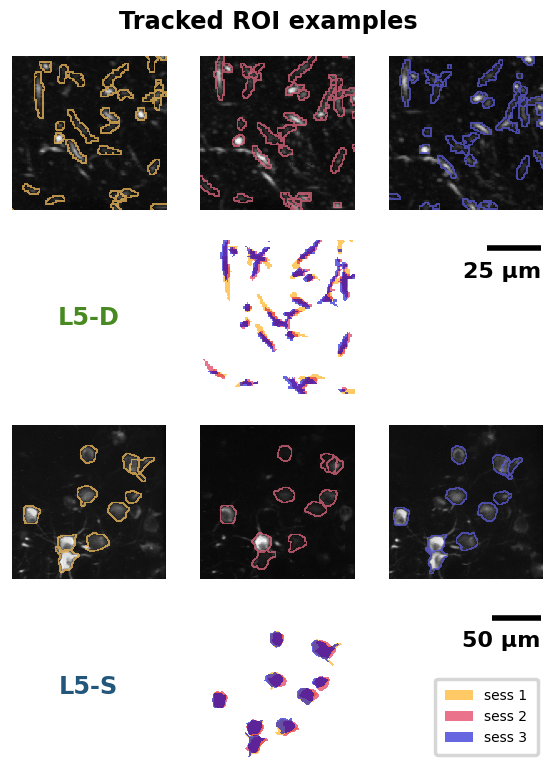

In [9]:
data_dict = load_data_dict(fig=2, panel="B", paper="dataset")

plot_roi_masks_overlayed_with_proj(roi_mask_df=data_dict["roi_mask_df"])

### Replication 2. Example ROI responses to inconsistent Gabor sequences (Dataset descriptor paper, Fig. 5B)

The following general function, `plot_ex_traces(ex_traces_df)`, plots example ROI responses to inconsistent Gabor sequences. It calls the function defined right below, `add_subplot_roi_traces(sub_ax, df_row)`, to plot traces in each individual plot.

In [10]:
def plot_ex_traces(ex_traces_df, title=None, rasterize=False):
    """
    plot_ex_traces(ex_traces_df)

    Plots example traces.

    Required args:
        - ex_traces_df (pd.DataFrame):
            dataframe with a row for each selected ROI, and the following columns, 
            in addition to the basic sess_df columns: 
            - time_values (list): time values for each frame, in seconds
            - roi_ns (list): selected ROI number
             - traces_sm (list): selected ROI sequence traces, smoothed, with 
                dims: seq x frames
            - trace_stat (list): selected ROI trace mean or median
    
    Optional args:
        - title (str):
            plot title
            default: None
        - rasterize (bool):
            if True, individual gray lines are rasterized 
            (if saving figure, reduces save time and file size)
            default: False
    """

    # aggregate plotting info
    group_columns = ["lines", "planes"]
    n_per = np.max(
        [len(lp_df) for _, lp_df in ex_traces_df.groupby(group_columns)]
        )
    per_rows = 3
    per_cols = int(np.ceil(n_per / per_rows))
    
    figpar = {
        "ncols": 2 * per_cols,
        "nrows": 2 * per_rows,
        "figsize": (2 * per_cols * 2.5, 2 * per_rows * 1.25),
        "sharex": True
    }
    
    # initialize figure
    fig, ax = plt.subplots(**figpar)

    if title is None:
        title = "Example ROI responses to inconsistent Gabor sequences"
    fig.suptitle(title, y=1.03, weight="bold")

    # plot traces
    print("    Plotting individual traces...")
    raster_zorder = -12
    ylims = np.full(ax.shape + (2, ), np.nan)
    for (line, plane), lp_df in ex_traces_df.groupby(["lines", "planes"]):
        li, pl = LINPLA_INFO[line][plane]["idx"]
        col = LINPLA_INFO[line][plane]["color"]
        dash = DASH[line]

        for i, idx in enumerate(lp_df.index):
            row_idx = int(pl * per_rows + i % per_rows)
            col_idx = int(li * per_cols + i // per_rows)
            sub_ax = ax[row_idx, col_idx]

            ylims[row_idx, col_idx] = add_subplot_roi_traces(
                sub_ax, lp_df.loc[idx], col=col, dash=dash,
                zorder=raster_zorder - 1
            )

        time_values = np.asarray(lp_df.loc[lp_df.index[-1], "time_values"])
    
    # label and adjust subplots
    cred_assign_utils.format_linpla_subaxes(ax)

    # set x ticks
    xvals = [np.around(xval, 1) for xval in [time_values.min(), time_values.max()]]
    step = np.min(np.absolute(xvals))
    if step == 0:
        step = np.max(np.absolute(xvals))
    xticks = [t for t in np.linspace(-step, step, 3) if t >= xvals[0] and t <= xvals[1]]
    for sub_ax in ax[-1]:
        sub_ax.set_xticks(xticks)
        sub_ax.set_xticklabels(xticks, weight="bold")  

    # rasterize the gray lines, if applicable (if saving figure, reduces save time and file size substantially)
    if rasterize:
        print("    Rasterizing individual traces...")
        for sub_ax in ax.reshape(-1):
            sub_ax.set_rasterization_zorder(raster_zorder)

In [11]:
def add_subplot_roi_traces(sub_ax, df_row, col="k", dash=None, zorder=-13):
    """
    add_subplot_roi_traces(sub_ax, df_row)

    Plots example traces in a subplot.

    Required args:
        - sub_ax (plt subplot):
            subplot
        - df_row (pd.Series): 
            pandas DataFrame row to plot from

    Optional args:
        - col (str):
            trace statistic color
            default: "k"
        - dash (tuple or None):
            dash pattern to use for trace statistic
            default: None
        - zorder (int):
            zorder for the individual traces 
            (zorder + 1 used for vertical dashed line at 0)
            default: -13

    Returns:
        - ylims (list): 
            rounded y limits to use for the subplot
    """

    sub_ax.axvline(x=0, ls=(0, (3, 2)), c="k", lw=3.0, 
        alpha=0.5, zorder=zorder + 1)

    time_values = df_row["time_values"]
    traces_sm = np.asarray(df_row["traces_sm"])
    trace_stat = df_row["trace_stats"]

    alpha = 2 / np.log(len(traces_sm))

    sub_ax.plot(
        time_values, traces_sm.T, lw=1, color="gray", alpha=alpha, 
        zorder=zorder
        )

    sub_ax.plot(time_values, trace_stat, color=col, alpha=0.8, ls=dash)
    
    # use percentiles to set bounds, asymmetrically
    ymin_near = np.min([np.min(trace_stat), np.percentile(traces_sm, 0.01)])
    ymax_near = np.max([np.max(trace_stat), np.percentile(traces_sm, 99.99)])

    yrange_near = ymax_near - ymin_near
    ymin = ymin_near - yrange_near * 0.05
    ymax = ymax_near + yrange_near * 0.05

    ylims = [ymin, ymax]

    return ylims

Specifically, for each of the four imaging planes, **six** example ROIs were selected from all the session 1 recordings (aggregated across mice). These ROIs were selected if they showed consistent responses to the Gabor sequences across sequence presentations. The fluorescence responses (&Delta;F/F) of the ROIs to each inconsistent sequence presentation are plotted in light gray. The mean response across inconsistent sequences is plotted in color. 

The example ROI responses for each imaging plane are arranged in a 2 column x 3 row quadrant (top left: L2/3-D, bottom left: L2/3-S, top right: L5-D, bottom right: L5-S). The vertical gray dashed lines at 0 seconds mark the onset of U images in the A-B-C-U-G sequences (going from -0.9 to 0.3 seconds). Additional gray dashed lines are plotted horizontally at 0, but are largely hidden by the gray traces. 

Time, as a function of Gabor sequence image:
- A: -0.9 to -0.6 seconds  
- B: -0.6 to -0.3 seconds  
- C: -0.3 to  0.0 seconds  
- U:  0.0 to  0.3 seconds  
- G:  0.3 to  0.6 seconds

Loading data for dataset paper Fig. 5B.
    Plotting individual traces...


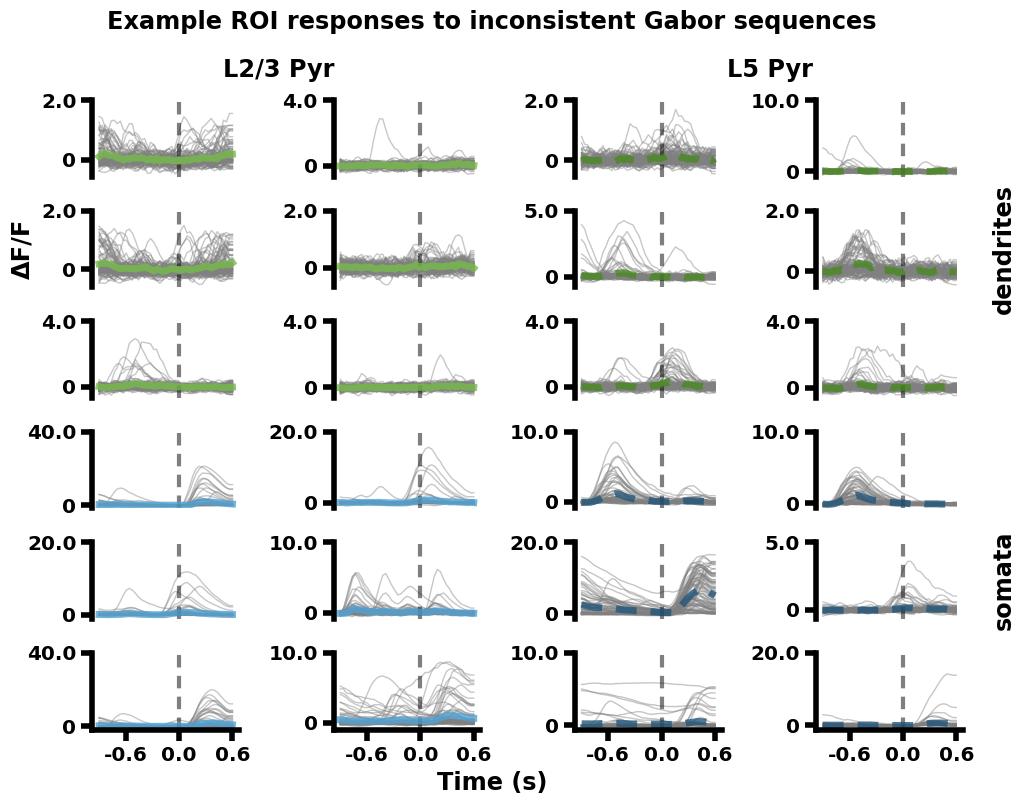

In [12]:
data_dict = load_data_dict(fig=5, panel="B", paper="dataset")

plot_ex_traces(ex_traces_df=data_dict["ex_traces_df"])

### Replication 3. Running velocity and pupil diameter traces across a full session (Dataset descriptor paper, Fig. 6A)

For each session, in addition to neuronal activity, running velocity and pupil diameter were recorded for each mouse. 

The following function, `plot_run_pupil_full(sess_df)`, plots the running velocity and pupil diameter traces for an example session.

In [13]:
def plot_run_pupil_full(sess_df, title=None):
    """
    plot_run_pupil_full(sess_df)

    Plots running and pupil data for a full session.

    Required args:
        - sess_df (pd.DataFrame):
            dataframe with one row per session, and the following columns, in 
            addition to the basic sess_df columns:
            - duration_sec (float):
                duration of the session in seconds
            - pup_data (list):
                pupil diameter data
            - pup_frames (list):
                start and stop pupil frame numbers for each stimulus type
            - run_data (list):
                running velocity data
            - run_frames (list):
                start and stop running frame numbers for each stimulus type
            - stims (list):
                stimulus types

    Optional args:
        - title (str):
            plot title
            default: None
    """
    
    datatypes = ["run", "pupil"]
    datatype_strs = ["Running velocity (cm/s)", "Pupil diameter (mm)"]
    n_datatypes = len(datatypes)
    
    # initialize figure
    height_ratios = [0.12] + [0.83 / len(datatypes) for _ in datatypes] + [0.05]
    fig, ax = plt.subplots(
        n_datatypes + 2, 1, figsize=(14, 6), squeeze=False, 
        gridspec_kw={"height_ratios": height_ratios}, sharex=True
        )
    
    # add title
    if title is None:
        title = "Full session running and pupil responses"
    fig.suptitle(title, y=0.98, weight="bold")

    # retrieve data
    if len(sess_df) != 1:
        raise ValueError("Expected sess_df to have one row.")
    sess_row = sess_df.loc[sess_df.index[0]]
    duration_sec = sess_row["duration_sec"]

    # plot traces for the session
    for d, datatype in enumerate(datatypes):
        sub_ax = ax[d + 1, 0]
        data = sess_row[f"{datatype}_data"]
        x = np.linspace(0, duration_sec, len(data))
        sub_ax.plot(x, data, color="k", alpha=0.8, lw=1.5)
        sub_ax.set_ylabel(
            datatype_strs[d].replace(" ", "\n"), labelpad=12, weight="bold"
            )
        sub_ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
        for label in sub_ax.get_yticklabels():
            label.set_fontweight("bold")
            label.set_fontsize("x-large")

    # minor aesthetic tweaks
    for sub_ax in ax.ravel():
        sub_ax.xaxis.set_visible(False)
        sub_ax.spines["bottom"].set_visible(False)

    for row in [0, -1]:
        ax[row, 0].yaxis.set_visible(False)
        ax[row, 0].spines["left"].set_visible(False)
        pad = duration_sec / 50
        ax[row, 0].set_xlim(-pad, duration_sec + pad)

    # add stimulus info
    data = sess_row[f"{datatype}_data"]
    fr_ranges = sess_row[f"{datatype}_frames"]
    x = np.linspace(0, duration_sec, len(data))
    ax[0, 0].set_ylim([-0.1, 0.5])
    for s, stim in enumerate(sess_row["stims"]):
        sec_ranges = [x[fr] for fr in fr_ranges[s]]
        ax[0, 0].plot(sec_ranges, [0, 0], lw=2.5, color="k")
        stim_str = stim.replace("right ", "").replace("left ", "")
        stim_str = stim_str.replace(" (", "\n").replace("))", ")")
        ax[0, 0].text(
            np.mean(sec_ranges), 0.45, stim_str, color="k", fontweight="bold", 
            fontsize="x-large", ha="center", va="center"
            )

    # add scale bar
    ax[-1, 0].plot([0, 60 * 5], [0, 0], lw=2.5, color="k")
    ax[-1, 0].set_ylim([-0.8, 0.1])
    ax[-1, 0].text(
        0, -1, "5 min", color="k", fontweight="bold", fontsize="x-large", 
        ha="left", va="center"
        )

Specifically, running velocity is plotted in the top row in cm/s, and pupil diameter is plotted in the bottom row, in mm. Sessions lasted 70 min in total, and the scale bar here represents 5 min. Above the plotted traces, the lines show the period during which each stimulus was presented. In this session, the stimuli were presented in the following order (left to right): Gabor sequence stimulus, nasal-to-temporal visual flow stimulus, and temporal-to-nasal visual flow stimulus. There are small gaps between the stimulus presentation lines as each stimulus was preceded and followed by at least 30 seconds of grayscreen. 

Loading data for dataset paper Fig. 6A.


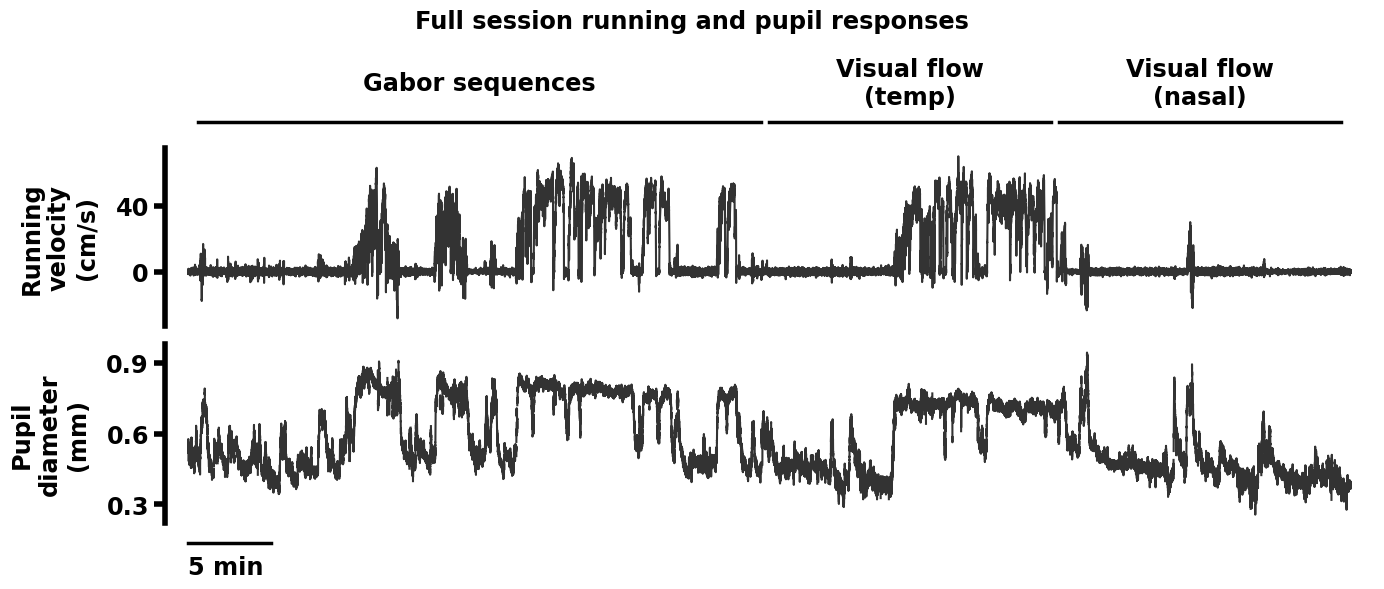

In [14]:
data_dict = load_data_dict(fig=6, panel="A", paper="dataset")

plot_run_pupil_full(sess_df=data_dict["sess_df"])

### Replication 4. Mean Gabor sequence responses for example ROIs (Analysis paper, Fig. 4A)

Unlike the previous figures, this figure is drawn from the analysis paper. In this paper, one of the metrics used to study patterns in ROI responses to consistent vs inconsistent stimuli was a selectivity index (USI), explained below. This plot shows responses of example ROIs from different imaging planes, with differing USIs. 

The following general function, `plot_chosen_roi_traces(chosen_rois_df)`, plots mean fluorescence responses (&Delta;F/F) to consistent and inconsistent Gabor sequences for example ROIs. It calls the function defined right below, `add_USI_boxes(ax, chosen_rois_df, sorted_target_idxs)`, to label each plot with its ROI's USI value.  

In [15]:
def plot_chosen_roi_traces(chosen_rois_df, title=None):
    """
    plot_chosen_roi_traces(chosen_rois_df) 
    
    Plots traces for chosen ROIs from dataframe.

    Required args:
        - chosen_rois_df (pd.DataFrame):
            traces data frame with, in addition to the basic sess_df columns, 
            with columns:
            - "target_idxs" (str): index values and significance aimed for
            - "roi_idxs" (float): index of the chosen ROI
            - "roi_idx_percs" (float): index percentile for the chosen ROI 
            - "roi_ns" (int): chosen ROI's number within its session
            - "roi_trace_stats" (list): 
                ROI trace statistics (split x frames x stat (me, err))
            - time_values (list):
                time values for each frame, in seconds
        
    Optional args:
        - title (str):
            plot title
            default: None
    """
    
    target_idxs = chosen_rois_df["target_idxs"].unique()
    target_idx_vals = [float(idx.split("_")[0]) for idx in target_idxs]
    sorted_target_idxs = [
        target_idxs[i] for i in np.argsort(target_idx_vals)[::-1]
        ]
    
    # aggregate plotting info
    per_rows = len(sorted_target_idxs)
    figpar = {
        "ncols": 2,
        "nrows": 2 * per_rows,
        "figsize": (2 * 3.7, 2 * per_rows * 1.51),
        "sharex": True
    }

    # initialize figure
    fig, ax = plt.subplots(**figpar)
    if title is None:
        title = "Gabor sequences (example ROIs)"
    fig.suptitle(title, y=1.03, weight="bold")

    # plot traces
    for (line, plane), lp_df in chosen_rois_df.groupby(["lines", "planes"]):
        li, pl = LINPLA_INFO[line][plane]["idx"]
        col = LINPLA_INFO[line][plane]["color"]
        dash = DASH[line]

        for r, row_val in enumerate(sorted_target_idxs):
            rows = lp_df.loc[lp_df["target_idxs"] == row_val]
            if len(rows) == 0:
                continue
            elif len(rows) > 1:
                raise RuntimeError(
                    "Expected row_order instances to be unique per line/plane."
                    )
            row = rows.loc[rows.index[0]]
            sub_ax = ax[r + pl * len(sorted_target_idxs), li]

            if line == "L2/3-Cux2":
                exp_col = "darkgray" # oddly, lighter than gray
            else:
                exp_col = "gray"

            # horizontal 0 line
            sub_ax.axhline(y=0, ls=(0, (4, 2)), c="k", lw=3.0, alpha=0.5, zorder=-13)
            sub_ax.axvline(x=0, ls=(0, (3, 2)), c="k", lw=3.0, alpha=0.5, zorder=-13)

            # plot data
            time_values = np.asarray(row["time_values"])
            trace_st = np.asarray(row["roi_trace_stats"])
            for i, (col, name) in enumerate(zip([exp_col, col], ["exp", "unexp"])):
                sub_ax.plot(
                    time_values, trace_st[i, :, 0], color=col, alpha=0.8, ls=dash
                    )
                up = trace_st[i, :, 0] + trace_st[i, :, 1]
                down = trace_st[i, :, 0] - trace_st[i, :, 1]
                sub_ax.fill_between(time_values, down, up, facecolor=col, alpha=0.5)

    # set y ticks
    for sub_ax in ax.reshape(-1):
        sub_ax.autoscale()
        ylims = sub_ax.get_ylim()
        ylim = np.absolute(ylims).max()

        # get the rounding order
        o = int(np.ceil(-np.log(ylim) / np.log(10)))
        ylim = np.around(ylim, o)
        new_lims = [np.around(y, o) for y in ylims]
        yticks = [y for y in [-ylim, 0, ylim] if y >= new_lims[0] and y <= new_lims[1]]

        sub_ax.set_yticks(yticks)
        sub_ax.set_ylim(new_lims)

    # label and adjust subplots
    cred_assign_utils.format_linpla_subaxes(ax)

    # set x ticks
    xvals = [np.around(xval, 1) for xval in [time_values.min(), time_values.max()]]
    step = np.min(np.absolute(xvals))
    if step == 0:
        step = np.max(np.absolute(xvals))
    xticks = [t for t in np.linspace(-step, step, 3) if t >= xvals[0] and t <= xvals[1]]
    for sub_ax in ax[-1]:
        sub_ax.set_xticks(xticks)
        sub_ax.set_xticklabels(xticks, weight="bold")  
        
    # add USI values
    add_USI_boxes(ax, chosen_rois_df, sorted_target_idxs)

In [16]:
def add_USI_boxes(ax, chosen_rois_df, sorted_target_idxs): 
    """
    add_USI_boxes(ax, chosen_rois_df, sorted_target_idxs)

    Adds boxes with USI values to individual plots (e.g., trace plots).

    Required args:
        - ax (subplot array):
            pyplot axis array
        - chosen_rois_df (pd.DataFrame):
            chosen ROIs dataframe with, in addition to the basic sess_df 
            columns:
            - "target_idxs" (str): index values and significance aimed for
            - "roi_idxs" (float): index of the chosen ROI
        - sorted_target_idxs (list): 
            order in which different target_idxs should be added to subplots
    """
    props = dict(
        boxstyle="round", facecolor="white", edgecolor="black", alpha=0.5, 
        lw=1.5)

    for (line, plane), lp_df in chosen_rois_df.groupby(["lines", "planes"]):
        li, pl = LINPLA_INFO[line][plane]["idx"]

        for r, row_val in enumerate(sorted_target_idxs):
            rows = lp_df.loc[lp_df["target_idxs"] == row_val]
            if len(rows) == 0:
                continue
            elif len(rows) > 1:
                raise RuntimeError(
                    "Expected row_order instances to be unique per line/plane."
                    )

            row = rows.loc[rows.index[0]]
            sub_ax = ax[r + pl * len(sorted_target_idxs), li]

            # place a text box in upper left in axes coords
            sub_ax.text(0.1, 0.9, f"USI = {row['roi_idxs']:.2f}", 
                transform=sub_ax.transAxes, fontsize=13, va="center", 
                bbox=props)

Specifically, for each ROI in each recording session, a Gabor sequence selectivity index (USI) was calculated. This selectivity index reflects the degree to which an ROI selectively responds to inconsistent (=> positive USI) or consistent (=> negative USI) sequences. Null USIs (i.e., USIs close to 0) reflect no selectivity to either consistent or inconsistent sequences.

To provide examples of the fluorescence responses of ROIs with differing USIs, **three** example ROIs were selected for each imaging plane: one with a USI significantly above 0 (top), one with a USI significantly below 0 (bottom) and one with a USI close to 0 (middle). For each ROI, the mean fluorescence response (&Delta;F/F) is plotted in gray for consistent sequences and in color for inconsistent sequences.  

The same quadrant and color scheme is used for the imaging planes as in Replication 2. In addition, vertical gray dashed lines mark the onset of D/U images at 0 seconds in the A-B-C-D/U-G sequences (going from -0.9 to 0.3 seconds), while horizontal gray dashed lines mark 0. Each plot is labeled with its ROI's USI value.

Since USIs were computed on the D-G vs U-G parts of the sequences, where the stimulus patterns diverge, the differences between the mean traces relevant to the USI values occur _after_ the gray line, from 0 seconds onwards. 

Time, as a function of Gabor sequence image:
- A  : -0.9 to -0.6 seconds  
- B  : -0.6 to -0.3 seconds  
- C  : -0.3 to  0.0 seconds  
- D/U:  0.0 to  0.3 seconds  
- G  :  0.3 to  0.6 seconds

Loading data for analysis paper Fig. 4A.


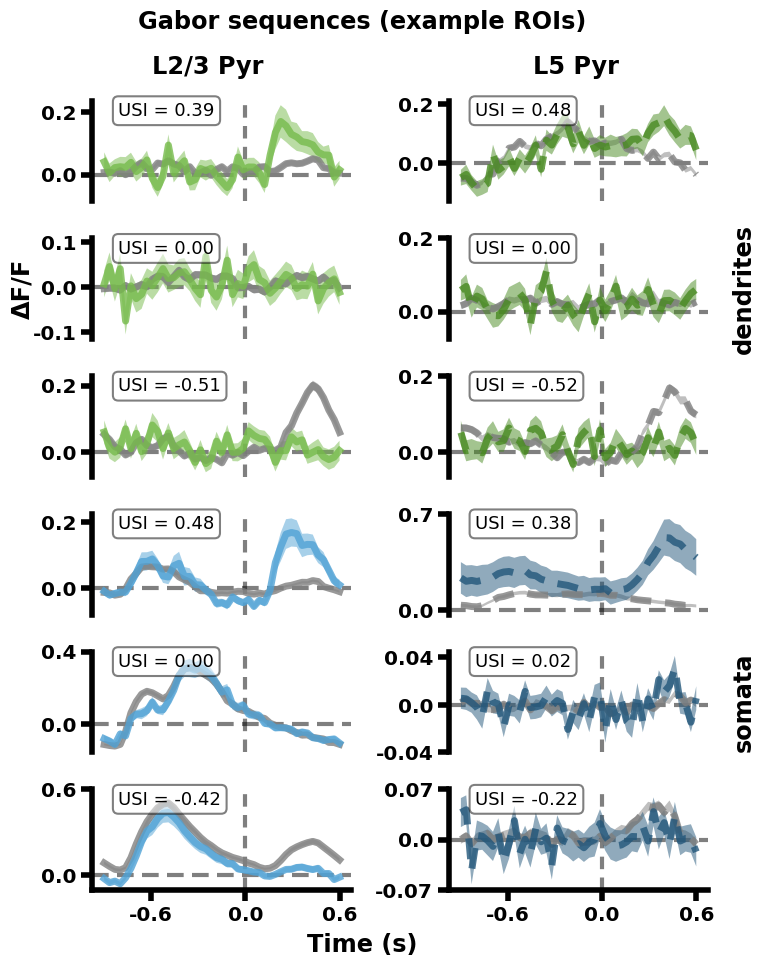

In [17]:
data_dict = load_data_dict(fig=4, panel="A", paper="analysis")

plot_chosen_roi_traces(chosen_rois_df=data_dict["chosen_rois_df"])

## Going further
As mentioned above, these examples show how to plot a few sample figures from the dataset descriptor paper {cite}`Gillon2023`, and one figure from the analysis paper {cite}`Gillon2024` using presaved data dictionaries. 

To understand the full scope of the dataset and analyses, please consult these papers. To work with the full analysis pipeline for this dataset, from NWB data files to final plots, see the [OpenScope_CA_Analysis](https://github.com/colleenjg/OpenScope_CA_Analysis) GitHub repository.